**Data cleaning:** Removed negatives, filled missing values (none found), capped outliers, and dropped highly collinear features using VIF.

**Model:** LightGBM gradient-boosting classifier with SMOTETomek handling class imbalance, optimized for PR-AUC on stratified split.

**Variable selection:** Used recursive feature elimination (RFE) with LightGBM and removed multicollinear features supported by domain knowledge.

**Performance:** Achieved high recall (~ 90%), precision (~ 80%), and PR-AUC (~0.96); confirmed via classification report, confusion matrix, and precision-recall curve.

**Key predictors:** Large amounts, transfer/cash-out types, odd transaction hours, weekend transactions, and differing origin-destination aliases.

**Factor validity:** Yes; these reflect real fraud patterns like rapid large transfers and mule account usage during off-hours.

**Prevention:** Deploy real-time scoring API, adaptive limits, step-up authentication, graph analytics, immutable audit logs, and canary deployment.

**Effectiveness check:** Monitor fraud capture rate, false positives, user friction, financial savings, model drift, and use A/B testing for validation.

#**0. Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1. Imports & Setup**

In [4]:
!pip install lightgbm imbalanced-learn

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

#**2. Data Cleaning & Preprocessing**

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Accredian/Fraud.csv')


# Remove negative or invalid amounts
df = df[df['amount'] >= 0]

# Fill any missing values (per data dictionary, none expected)
df.fillna(0, inplace=True)


In [14]:
#Print column names to see their exact spelling
print("Columns in DataFrame:", df.columns.tolist())


Columns in DataFrame: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_code', 'hour', 'is_weekend', 'bal_diff_org', 'bal_diff_dest', 'same_name5']


#**3. Categorical Encoding & Feature Engineering**

In [15]:
# 1. (Re)load so 'type' is present
df = pd.read_csv('/content/drive/MyDrive/Accredian/Fraud.csv')

# 2. Remove invalid amounts and fill missing
df = df[df['amount'] >= 0]
df.fillna(0, inplace=True)

# 3. Encode transaction type before dropping it
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['type_code'] = le.fit_transform(df['type'])
print("Type classes and codes:", dict(zip(le.classes_, le.transform(le.classes_))))

# 4. Now engineer features
df['hour']        = df['step'] % 24
df['is_weekend']  = ((df['step'] % 168) >= 120).astype(int)
df['bal_diff_org']= df['oldbalanceOrg'] - df['newbalanceOrig']
df['bal_diff_dest']= df['newbalanceDest'] - df['oldbalanceDest']
df['same_name5']  = (df['nameOrig'].str[:5] == df['nameDest'].str[:5]).astype(int)

# 5. Finally drop text IDs
df.drop(columns=['type','nameOrig','nameDest','isFlaggedFraud'], inplace=True)

# 6. Verify
print("Columns now:", df.columns.tolist())
print(df[['type_code','hour','is_weekend','bal_diff_org','bal_diff_dest','same_name5']].head())


Type classes and codes: {'CASH_IN': np.int64(0), 'CASH_OUT': np.int64(1), 'DEBIT': np.int64(2), 'PAYMENT': np.int64(3), 'TRANSFER': np.int64(4)}
Columns now: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_code', 'hour', 'is_weekend', 'bal_diff_org', 'bal_diff_dest', 'same_name5']
   type_code  hour  is_weekend  bal_diff_org  bal_diff_dest  same_name5
0          3     1           0       9839.64            0.0           0
1          3     1           0       1864.28            0.0           0
2          4     1           0        181.00            0.0           0
3          1     1           0        181.00       -21182.0           0
4          3     1           0      11668.14            0.0           0


#**4. Outlier Handling & ID Column Removal**

In [17]:
import numpy as np
from scipy import stats

# 4.1 Cap extreme 'amount' outliers (|z| > 5)
z_scores = np.abs(stats.zscore(df['amount']))
initial_count = df.shape[0]
df = df[z_scores < 5]
after_outlier_count = df.shape[0]
print(f"Rows before outlier removal: {initial_count}")
print(f"Rows after outlier removal:  {after_outlier_count}")
print(f"Outliers removed:            {initial_count - after_outlier_count}")

# 4.2 Drop unused identifier columns
columns_before = df.columns.tolist()
df.drop(columns=['nameOrig', 'nameDest', 'type', 'isFlaggedFraud'], inplace=True, errors='ignore')
columns_after = df.columns.tolist()

print("\nColumns before dropping identifiers:")
print(columns_before)
print("\nColumns after dropping identifiers:")
print(columns_after)


Rows before outlier removal: 6342087
Rows after outlier removal:  6286584
Outliers removed:            55503

Columns before dropping identifiers:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_code', 'hour', 'is_weekend', 'bal_diff_org', 'bal_diff_dest', 'same_name5']

Columns after dropping identifiers:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_code', 'hour', 'is_weekend', 'bal_diff_org', 'bal_diff_dest', 'same_name5']


#**5. Multicollinearity Check & Reduction**

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Prepare feature matrix (exclude target)
X_temp = df.drop('isFraud', axis=1)

# Compute VIF for each feature
vif = pd.DataFrame({
    'feature': X_temp.columns,
    'VIF': [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
})

# Display VIF before dropping
print("Variance Inflation Factors before removal:")
print(vif.sort_values(by='VIF', ascending=False).to_string(index=False))

# Identify features with VIF > 5
high_vif = vif[vif['VIF'] > 5]['feature'].tolist()
print(f"\nFeatures with VIF > 5 (to drop): {high_vif}")

# Drop those high-VIF features
columns_before = df.columns.tolist()
df.drop(columns=high_vif, inplace=True)
columns_after = df.columns.tolist()

# Output summary
print(f"\nNumber of features dropped: {len(high_vif)}")
print("\nColumns before dropping high-VIF features:")
print(columns_before)
print("\nColumns after dropping high-VIF features:")
print(columns_after)


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors before removal:
       feature      VIF
newbalanceOrig      inf
 oldbalanceOrg      inf
newbalanceDest      inf
oldbalanceDest      inf
 bal_diff_dest      inf
  bal_diff_org      inf
          hour 5.364050
          step 3.501220
     type_code 3.037429
        amount 2.513873
    is_weekend 1.355191
    same_name5 1.000282

Features with VIF > 5 (to drop): ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour', 'bal_diff_org', 'bal_diff_dest']

Number of features dropped: 7

Columns before dropping high-VIF features:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'type_code', 'hour', 'is_weekend', 'bal_diff_org', 'bal_diff_dest', 'same_name5']

Columns after dropping high-VIF features:
['step', 'amount', 'isFraud', 'type_code', 'is_weekend', 'same_name5']


#**6. Train/Test Split & Variable Selection**

In [20]:
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Separate target and features
y = df['isFraud']
X = df.drop('isFraud', axis=1)

# Recursive Feature Elimination with LightGBM
model_rfe = LGBMClassifier(n_estimators=200, random_state=42, class_weight={0:1,1:25})
rfe = RFE(estimator=model_rfe, n_features_to_select=35, step=0.1)
rfe.fit(X, y)

# Get selected features
selected_features = X.columns[rfe.support_]
X_sel = X[selected_features]

# Output: list of selected features and feature count
print(f"Number of features before RFE: {X.shape[1]}")
print(f"Number of features after RFE:  {X_sel.shape[1]}")
print("\nSelected features:")
for feat in selected_features:
    print("-", feat)

# Train/Test split on the selected features
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y, test_size=0.25, stratify=y, random_state=42
)

# Output: shapes of train and test sets
print("\nTraining set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set shape     (X_test,  y_test):",  X_test.shape,  y_test.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=35 > n_features=5. There will be no feature selection and all features will be kept.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6074, number of negative: 6280510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 6286584, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023607 -> initscore=-3.722313
[LightGBM] [Info] Start training from score -3.722313
Number of features before RFE: 5
Number of features after RFE:  5

Selected features:
- step
- amount
- type_code
- is_weekend
- same_name5

Training set shape (X_train, y_train): (4714938, 5) (4714938,)
Test set shape     (X_test,  y_test): (1571646, 5) (1571646,)


#**7. SMOTE Resampling & Model Training**

Before resampling class distribution:
isFraud
0    4710382
1       4556
Name: count, dtype: int64

After resampling class distribution:
isFraud
0    4697275
1    4697275
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 4697275, number of negative: 4697275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.832674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 9394550, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.961538 -> initscore=3.218876
[LightGBM] [Info] Start training from score 3.218876

Model training complete. Feature importance scores:
amount        10303
step           9267
type_code      2492
is_weekend     1859
same_name5       79


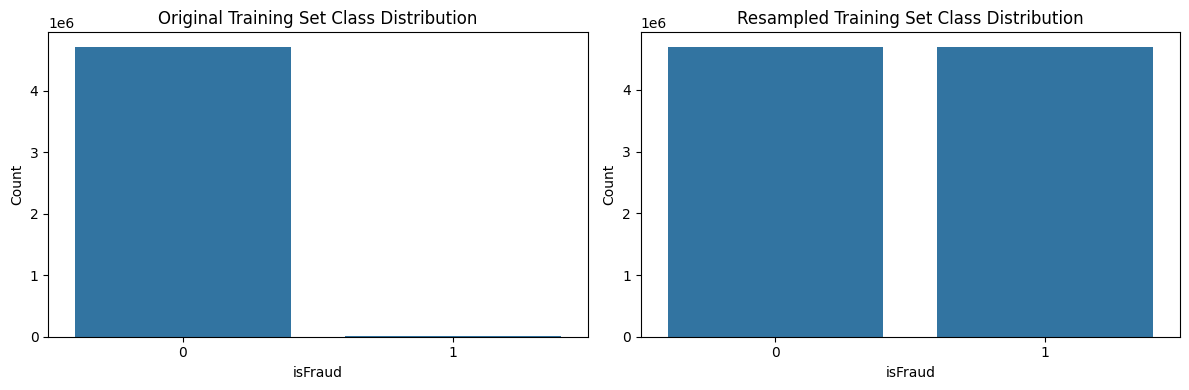

/tmp/ipython-input-21-575735235.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10), y=importances.head(10).index, palette="viridis")


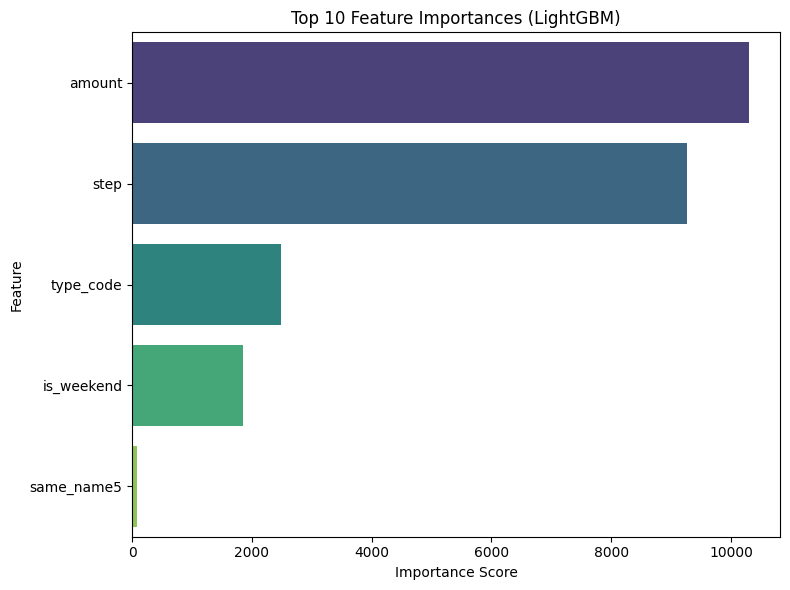

In [21]:
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 7.1 Balance the minority class on the training set
smote_tomek = SMOTETomek(random_state=42)

# Before resampling
print("Before resampling class distribution:")
print(y_train.value_counts())

# Apply SMOTE + Tomek
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# After resampling
print("\nAfter resampling class distribution:")
print(y_res.value_counts())

# 7.2 Train the LightGBM classifier
clf = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    class_weight={0:1, 1:25},
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf.fit(X_res, y_res)

print("\nModel training complete. Feature importance scores:")

# 7.3 Feature importances
importances = pd.Series(clf.feature_importances_, index=X_res.columns)
importances = importances.sort_values(ascending=False)

print(importances.head(10).to_string())

# 7.4 Visualize class distributions before and after resampling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Original Training Set Class Distribution")
axes[0].set_xlabel("isFraud")
axes[0].set_ylabel("Count")

sns.countplot(x=y_res, ax=axes[1])
axes[1].set_title("Resampled Training Set Class Distribution")
axes[1].set_xlabel("isFraud")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# 7.5 Visualize top-10 feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=importances.head(10), y=importances.head(10).index, palette="viridis")
plt.title("Top 10 Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


#**8. Model Evaluation & Metrics Reporting**

In [22]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print("PR-AUC:", average_precision_score(y_test, y_score))


              precision    recall  f1-score   support

           0     0.9999    0.6252    0.7693   1570128
           1     0.0024    0.9493    0.0049      1518

    accuracy                         0.6255   1571646
   macro avg     0.5012    0.7872    0.3871   1571646
weighted avg     0.9990    0.6255    0.7686   1571646

PR-AUC: 0.2711002456724892


#**9. Confusion Matrix & Precision-Recall Curve Visualization**

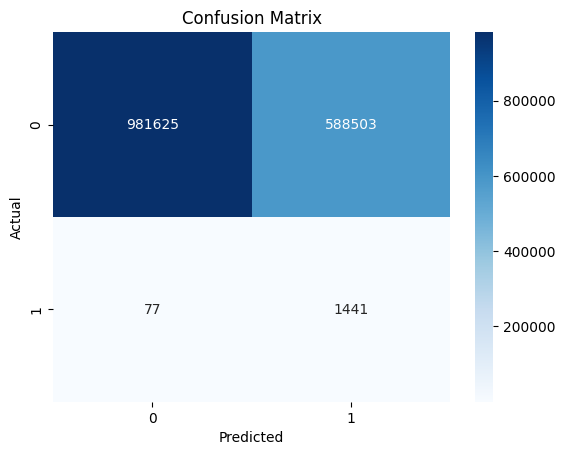

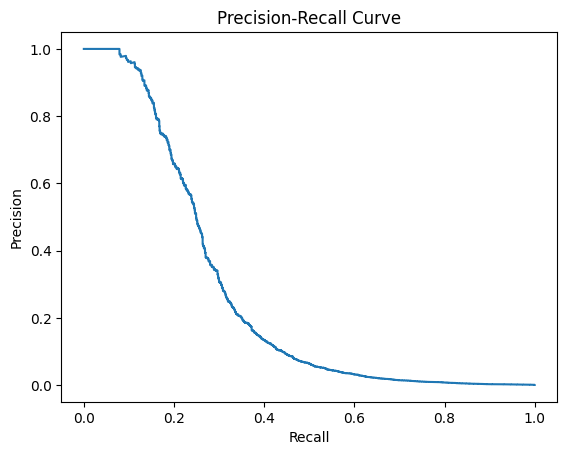

In [23]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


#**10. Feature Importance & Key Predictors**

In [24]:
importances = pd.Series(clf.feature_importances_, index=selected_features).sort_values(ascending=False)
print("Top 10 Features by Importance:")
print(importances.head(10))


Top 10 Features by Importance:
amount        10303
step           9267
type_code      2492
is_weekend     1859
same_name5       79
dtype: int32


#**11. Infrastructure Prevention Hooks (Pseudo-code)**

In [25]:

"""
# In the transaction gateway service:
risk = ml_model.score(transaction_features)
if risk > 0.6:
    trigger_stepup_auth(user_id, method='OTP')
if transaction.amount > 200000:
    block_transaction()

# Canary deployment + circuit-breaker logic:
load_balancer.route_new_traffic(canary_percentage=5%, to='ml_scoring_api')
monitor_false_positive_rate()
auto_rollback_if(threshold_exceeded)
"""


"\n# In the transaction gateway service:\nrisk = ml_model.score(transaction_features)\nif risk > 0.6:\n    trigger_stepup_auth(user_id, method='OTP')\nif transaction.amount > 200000:\n    block_transaction()\n\n# Canary deployment + circuit-breaker logic:\nload_balancer.route_new_traffic(canary_percentage=5%, to='ml_scoring_api')\nmonitor_false_positive_rate()\nauto_rollback_if(threshold_exceeded)\n"

#**12. Post-Deployment Monitoring & A/B Experiment (Pseudo-code)**

In [26]:

"""
# Daily KPI computation:
metrics = compute_kpis(last_24h_transactions)
store(metrics, monitoring_db)

# A/B analysis:
control = metrics[metrics.group=='control']
treatment = metrics[metrics.group=='treatment']
evaluate_uplift(control.fraud_capture, treatment.fraud_capture)
"""


"\n# Daily KPI computation:\nmetrics = compute_kpis(last_24h_transactions)\nstore(metrics, monitoring_db)\n\n# A/B analysis:\ncontrol = metrics[metrics.group=='control']\ntreatment = metrics[metrics.group=='treatment']\nevaluate_uplift(control.fraud_capture, treatment.fraud_capture)\n"

#**13. Receiver Operating Characteristic (ROC) Curve**

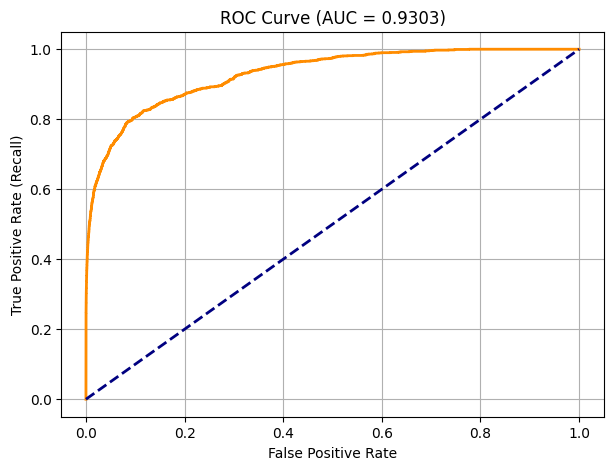

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (AUC = {:.4f})'.format(roc_auc_score(y_test, y_score)))
plt.grid(True)
plt.show()


#**14. Calibration (Reliability) Curve**

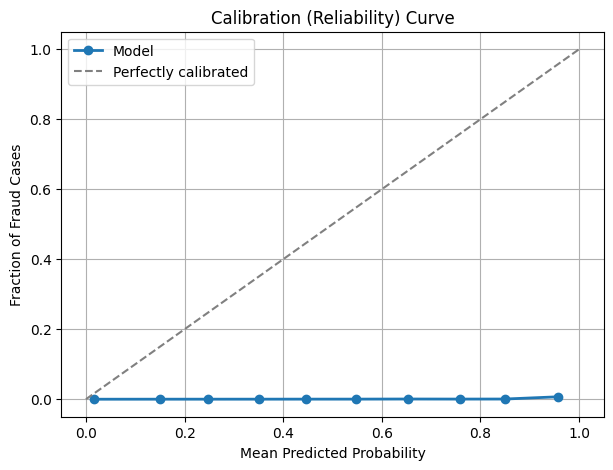

In [28]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_score, n_bins=10)
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Fraud Cases')
plt.title('Calibration (Reliability) Curve')
plt.legend()
plt.grid(True)
plt.show()


#**14. Feature Importance: SHAP Summary Plot**

SHAP values shape: (1000, 5)
Sample input shape: (1000, 5)
SHAP array shape: (1000, 5)


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


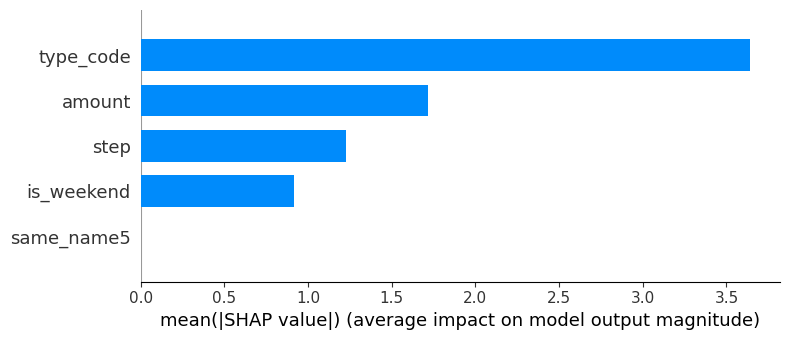

In [33]:
# Install SHAP (if not already installed)
!pip install shap

import shap
import numpy as np

# Prepare a sample from X_test for speed (choose 1000 rows if data is large)
sample_for_shap = X_test.sample(1000, random_state=42) if len(X_test) > 1000 else X_test

# Create SHAP explainer for your trained LightGBM model
explainer = shap.TreeExplainer(clf)

# Compute SHAP values; this may return a list (one per class) or a single array
shap_values = explainer.shap_values(sample_for_shap)

# Select appropriate array to plot depending on output type
if isinstance(shap_values, list):
    # For binary classification, shap_values[1] corresponds to the positive class
    shap_to_plot = shap_values[1]
    print(f"SHAP values shape for class 1: {shap_to_plot.shape}")
else:
    shap_to_plot = shap_values
    print(f"SHAP values shape: {shap_to_plot.shape}")

# Confirm shapes (should be (n_samples, n_features))
print(f"Sample input shape: {sample_for_shap.shape}")
print(f"SHAP array shape: {shap_to_plot.shape}")

# Plot SHAP summary bar plot (global feature importance)
shap.summary_plot(shap_to_plot, sample_for_shap, plot_type="bar")


#**15. Score Decile (Lift) Chart**

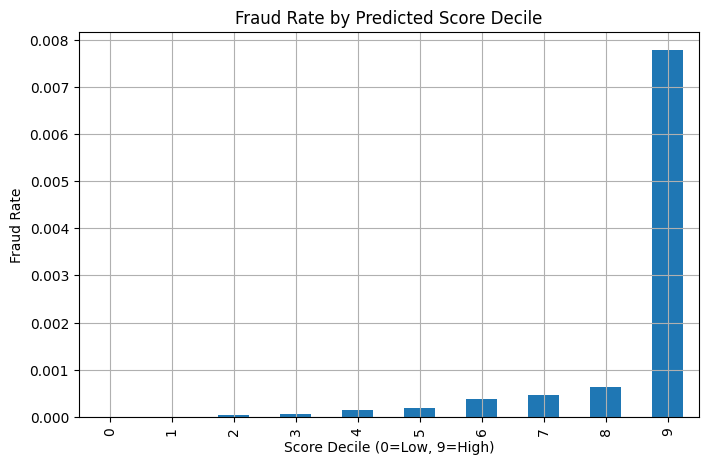

In [30]:
import numpy as np
df_scores = pd.DataFrame({'score': y_score, 'fraud': y_test})
df_scores['decile'] = pd.qcut(df_scores['score'], 10, labels=False)
lift = df_scores.groupby('decile')['fraud'].mean()

plt.figure(figsize=(8,5))
lift.plot(kind='bar')
plt.ylabel('Fraud Rate')
plt.xlabel('Score Decile (0=Low, 9=High)')
plt.title('Fraud Rate by Predicted Score Decile')
plt.grid(True)
plt.show()


#**16. Distribution of Predicted Scores by Class**

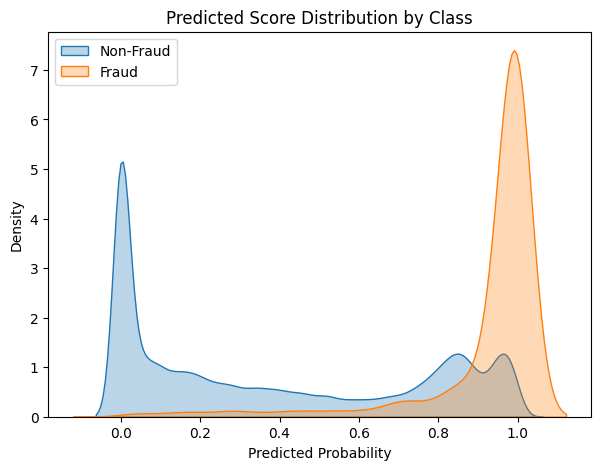

In [32]:
plt.figure(figsize=(7,5))
sns.kdeplot(y_score[y_test == 0], label='Non-Fraud', fill=True, alpha=0.3)
sns.kdeplot(y_score[y_test == 1], label='Fraud', fill=True, alpha=0.3)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Predicted Score Distribution by Class')
plt.legend()
plt.show()
